<div style="background-color: #004B87; padding: 20px; border-radius: 10px;">
    <img src="https://cdn-assets-us.frontify.com/s3/frontify-enterprise-files-us/eyJwYXRoIjoibWlsbGltYW5cL2ZpbGVcL2l3dHhYOHJqV3pVUUV0R3hLc0FGLnN2ZyJ9:milliman:1F1qJpvDxGMTndryYS7nEiCYPRFCCi7l2rEhgnpdkGo?width=2400" width="300" height="150" alt="SVG Image" />
    <center>
        <div style="font-size: 3em;">IABE Data Science Certificate</div>
        <div style="font-size: 2em;"> Module 2 - Session 8 - Neural Networks and deep learning</div>
        <div style="font-size: 1em;">10th April, 2025</div>
    </center>
</div>

# Neural Networks and deep learning

In this notebook, Neural Networks using ```keras``` are explored. They are applied to an actuarial context to predict insurance claims frequency and severity amount. The results are compared to the ones obtained with previously implemented GLMs. Finally, to explore further applications, an example of Convolutional Neural Networks in the context of image recognition is showed.

## Objectives
- Perform data loading, exploration, and cleaning.
- Understand Neural Network methods.
- Build and evaluate Neural Networks.
- Compare these models with previously implemented GLMs
- Explore further applications (image recognition)

## Table of Contents
1. [Preparation](#preparation)
2. [Frequency of claims: the GLM model](#freq_GLM)
3. [Frequency of claims: Neural Network model](#freq_NN)
    <br /> 3.1. [Data preparation](#data_prep)
    <br /> 3.2. [Model setup](#model_setup)
      <br /> 3.2.1. [Input layer](#input_layer)
      <br /> 3.2.2. [Hidden layers](#hidden_layers)
      <br /> 3.2.3. [Output layer](#output_layer)
      <br /> 3.2.4. [Visualization of the model](#vis_model)
    <br /> 3.3. [Model fitting](#model_fitting)
    <br /> 3.4. [Hyperparameters tuning](#hyp_tuning)
    <br /> 3.5. [Explaining the model](#explaining)
4. [Frequency of claims: comparison between GLM and Neural Networks](#freq_NN_vs_GLM)
5. [Severity of claims: Neural Network model](#sev_NN)
6. [Advantages and disadvantages of Neural Networks](#adv_dis_NN)
7. [Image recognition](#img_rec)
8. [Summary](#sum)

## Speakers

**Raymond van Es**
<br />
Raymond is a consultant with 20+ years of experience in financial services, with a focus on data science and modelling.
<br />
Mail address: raymond.vanEs@milliman.com


**Jan Thiemen Postema**
<br />
Jan Thiemen is a consultant with 5+ years of experience in data science and machine learning.
<br />
Mail address: janthiemen.postema@milliman.com



## Resources
<ins>**Books and articles**</ins>
<br />
Denuit, M., Hainaut, D., Trufin, J. (Ed.). (2010). Effective Statistical Learning Methods for Actuaries III, Neural Networks and extensions. Springer Actuarial.
<br />

Merz, M., Wüthrich, M. V. (Ed.). (2023). Statistical Foundations of Actuarial Learning and its Applications. Springer Actuarial.
<br />

Li, L., Jamieson, K., DeSalvo, G., Rostamizadeh, A., Talwalkar, A. (2018). Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization, Journal of Machine Learning Research.
<br />
<br />
<ins>**Datasets**</ins>
<br />
Two French MTPL datasets, already used in previous sessions, on frequency and severity of claims will be considered:
<br />a. [Frequency data](https://www.kaggle.com/datasets/floser/french-motor-claims-datasets-fremtpl2freq)
<br />b. [Severity data](https://www.kaggle.com/datasets/floser/fremtpl2sev)

Moreover, for a short example on image recognition, a dataset on vehicles damages will be used:
<br />c. [Vehicle damages](https://www.kaggle.com/datasets/gauravduttakiit/vehicle-damage-identification)



# Preparation <a name="preparation" />

## Libraries and Setup <a name="libs_setup"></a>

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Data
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Model data prep
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# GLM
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Neural Networks
from graphviz import Digraph
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
import shap
import keras_tuner as kt

# General tools
from abc import ABC, abstractmethod
import os
from tqdm import tqdm
import kagglehub
import warnings

## Data Loading

The Insurance Claim Dataset will be used. This dataset contains information about insurance policies, including demographics, claim number, policy exposure and claim amount.

In [ ]:
# Load the dataset
mtpl_freq = pd.read_csv("/content/sample_data/freMTPL2freq.csv")
mtpl_sev = pd.read_csv("/content/sample_data/freMTPL2sev.csv")

## Dealing with NaN values<a name="Dealing_with_NaN_values"></a>

Similarly to the previous sessions, NaN values are substituted with the mode or the mean per variable. Even though Neural Networks can handle currupted and incomplete data, having NaN values could lead the weights of some neurons to increase too much. This could cause the loss function to have a NaN value.


In [ ]:
# Replacing NA values by the mode ot the mean

# Dataset on claims frequency
for i in list(mtpl_freq):
  if mtpl_freq[i].dtype == 'object':
    val = mtpl_freq[i].mode()[0]
    mtpl_freq[i] = mtpl_freq[i].fillna(val)
  elif pd.api.types.is_numeric_dtype(mtpl_freq[i]):
    val = mtpl_freq[i].mean()
    mtpl_freq[i] = mtpl_freq[i].fillna(val)


# Dataset on claims severity
for i in list(mtpl_sev):
  if mtpl_sev[i].dtype == 'object':
    val = mtpl_sev[i].mode()[0]
    mtpl_sev[i] = mtpl_sev[i].fillna(val)
  elif pd.api.types.is_numeric_dtype(mtpl_sev[i]):
    val = mtpl_sev[i].mean()
    mtpl_sev[i] = mtpl_sev[i].fillna(val)

# Frequency of claims: the GLM model <a name="freq_GLM"></a>

In this subsection, a GLM model for the frequency of claims will be developed. This was done in Module 1, Session 2. As a reminder, an overview of the dataset on claims frequency is displayed below:


In [ ]:
#Display first rows of the dataset
display(mtpl_freq.head())

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


First, the dependent variable of interest is calculated. It is represented by the frequency of claims, which can be obtained by dividing the number of claims by the exposure. This allows the conversion of observations on number of claims to an annual basis and therefore enhances comparability among different observations.

In [ ]:
X_freq=mtpl_freq.drop(columns=['ClaimNb', 'Exposure'])
y_freq=mtpl_freq['ClaimNb']/mtpl_freq['Exposure']

In a GLM model, numerical explanatory variables need to be split up in buckets. The same buckets that were selected in Module 1 Session 2 are implemented below:


In [ ]:
# Define intervals for the explanatory variables:
labelsVehAge = ['0-1', '1-20', '20-25', '25-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-100']
labelsDrivAge = ['18-20', '20-25', '25-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-100']
labelsBonusMalus = ['50-75', '75-100', '100-150', '150-230']
labelsVehPower = ['4-7', '7-9', '9-11', '11-13', '13-15']
labelsDensity = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000-6000', '6000-10000', '10000-30000']

X_freq["VehAge_cat"] = pd.cut(mtpl_freq.VehAge, bins = [0, 1, 20, 25, 30, 40, 50, 60, 70, 80, max(mtpl_freq.DrivAge)], labels = labelsVehAge, include_lowest = True)
X_freq["DrivAge_cat"] = pd.cut(mtpl_freq.DrivAge, bins = [18, 20, 25, 30, 40, 50, 60, 70, 80, max(mtpl_freq.DrivAge)], labels = labelsDrivAge, include_lowest = True)
X_freq["BonusMalus_cat"] = pd.cut(mtpl_freq.BonusMalus, bins = [50, 75, 100, 150, max(mtpl_freq.BonusMalus)], labels = labelsBonusMalus, include_lowest = True)
X_freq["VehPower_cat"] = pd.cut(mtpl_freq.VehPower, bins = [4, 7, 9, 11, 13, max(mtpl_freq.VehPower)], labels = labelsVehPower, include_lowest = True)
X_freq["Density_cat"] = pd.cut(mtpl_freq.Density, bins = [1, 1000, 2000, 3000, 4000, 5000, 6000, 10000, max(mtpl_freq.Density)], labels = labelsDensity, include_lowest = True)
X_freq['VehBrand_cat'] = mtpl_freq["VehBrand"].replace(['B2','B3', 'B4', 'B5', 'B6', 'B10', 'B11', 'B13', 'B14'],'Other')

Data is divided into a train and a test dataset in order to properly evaluate accuracy measures.

In [ ]:
# Split the data into training and test sets
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y_freq, test_size=0.2, random_state=42)

mtpl_train = X_train_freq
mtpl_train["Freq"] = y_train_freq

The GLM that was considered as the most appropriate in Module 1 Session 2 is presented again below. The chosen distribution is the Poisson one and the link function is set equal to the logarithm.

In [ ]:
Poisson = sm.formula.glm("Freq ~ VehAge_cat + DrivAge_cat + BonusMalus_cat + VehPower_cat + VehBrand + Density_cat", \
                              data = mtpl_train, family=sm.families.Poisson(link=sm.families.links.Log())).fit()
print(Poisson.summary())
print("------------------------------------------------------------------------------------------------------------------------")
print("Single metrics of interest:")
# MSE
y_pred_GLM = Poisson.predict(X_test_freq[['VehAge_cat', 'DrivAge_cat', 'BonusMalus_cat', 'VehPower_cat', 'VehBrand', 'Density_cat']])
mse_GLM = mean_squared_error(y_test_freq, y_pred_GLM)
print(f"Mean square error: {mse_GLM}")
# Deviance
print(f"Deviance: {Poisson.deviance:.2f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Freq   No. Observations:               542410
Model:                            GLM   Df Residuals:                   542368
Model Family:                 Poisson   Df Model:                           41
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.1324e+05
Date:                Wed, 19 Mar 2025   Deviance:                   1.1527e+06
Time:                        14:30:41   Pearson chi2:                 3.31e+07
No. Iterations:                    21   Pseudo R-squ. (CS):             0.1130
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

## Data preparation for the neural network  <a name="data_prep"></a>

Neural networks can only handle numeric data. To cope with this characteristic, **categorical features are one-hot encoded**. These models are also sensitive to outliers and differences in magnitude between variables. Therefore the **data is scaled**.

In [ ]:
scaler = StandardScaler()
# Prepare the data in order to standardize it. This involves dropping the ID column, selecting only the numeric columns
X_freq_numeric = X_freq\
    .drop(columns=['IDpol'])\
    .select_dtypes(include=['number'])

X_freq_scaled = pd.DataFrame(scaler.fit_transform(X_freq_numeric), columns=X_freq_numeric.columns, index=X_freq_numeric.index)

In [ ]:
X_freq_dummies = pd.get_dummies(X_freq[['Area', 'VehBrand', 'VehGas', 'Region']], columns=['Area', 'VehBrand', 'VehGas', 'Region']).astype(int)

As seen in the theoretical session, NNs need to use tensors, which are vectors or matrices with an arbitrary number of dimensions.

In [ ]:
# Create the feature dataframe
X_freq_NN = pd.concat([X_freq_dummies, X_freq_scaled], axis=1)

# Split the data in a training and test set
X_train_freq_NN, X_test_freq_NN, y_train_freq_NN, y_test_freq_NN = train_test_split(X_freq_NN, y_freq, test_size=0.2, random_state=42)

# DIY Neural Networks
To start, a very simple neural network will be implemented to properly understand how a neural network functions.

The network implemented below has these characteristics:
- it is a simple densely connected feed forward neural network
- it supports two activation functions: the sigmoid and the ReLU (more on those later on).

## The network
The network consists of the following components: the input, the hidden and the output layers. These are implemented below in a `NeuralNetwork` class.

In [ ]:
class NeuralNetwork:
    layers = []

    def __init__(self, input_size, output_size):
        # Initialize layers
        self.input_size = input_size
        self.output_size = output_size

    def add_hidden_layer(self, layer):
        if len(self.layers) == 0:
            layer.set_input_size(self.input_size)
        else:
            layer.set_input_size(self.layers[-1].output_size)

        self.layers.append(layer)

### Forward pass
When making a prediction, the data is processed by all layers 1-by-1. In a forward process, predictions are made on the basis of the input data.

In [ ]:
def forward(self, inputs):
    # Forward pass through layers
    for layer in self.layers:
        inputs = layer.forward(inputs)
    return inputs

NeuralNetwork.forward = forward

### Backpropagation
Next, a training method needs to be implemented. This training method performs the following tasks:
- calculate the error for every output in the training set
- call the backward method of every layer. This will be implemented later
- calculate the error to pass to the next layer, by multiplying it with the updated weights

In [ ]:
def train(self, inputs, outputs, learning_rate, epochs):
    for epoch in tqdm(range(epochs)):
        # Forward pass
        predicted_output = self.forward(inputs)

        # Calculate error
        output_error = outputs - predicted_output

        # Backward pass
        for layer in self.layers[::-1]:
            layer.backward(output_error, learning_rate)
            output_error = np.dot(output_error, layer.weights.T)

NeuralNetwork.train = train

### Activation functions
The following two activation functions will be implemented:
- Rectified Linear Unit (ReLU): $\max(0, x)$
- Sigmoid: $1/(1+e^x)$

### Excercise
Please implement the derivative of these activation functions in the code below.

In [ ]:
class ActivationFunction(ABC):
    @abstractmethod
    def __call__(self, x):
        pass

    @abstractmethod
    def derivative(self, x):
        pass


class Sigmoid(ActivationFunction):
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def derivative(self, x):
        return x * (1 - x)


class ReLU(ActivationFunction):
    def __call__(self, x):
        return np.maximum(0, x)

    def derivative(self, x):
        return np.where(x > 0, 1, 0)

### Layer
Finally, the definition of a layer needs to be given. In this example, a 1 type of layer, a fully connected one, is implemented.

In [ ]:
class Layer:
    def __init__(self, output_size, activation_function):
        self.activation_function = activation_function
        self.output_size = output_size

    def set_input_size(self, input_size):
        # Set the input size of the layer and initialize the weights randomly
        self.weights = np.random.rand(input_size, self.output_size)

    def forward(self, inputs):
        # Calculate the dot product and apply the sigmoid activation
        self.input = inputs
        self.output = self.activation_function(np.dot(self.input, self.weights))
        return self.output

    def backward(self, output_error, learning_rate):
        # Calculate the gradient
        gradient = output_error * self.activation_function.derivative(self.output)
        # Update the weights
        self.weights += np.dot(self.input.T, gradient) * learning_rate


### Using the network
The very small neural network described above is initialized.

In [ ]:
nn = NeuralNetwork(input_size=X_train_freq_NN.shape[1], output_size=1)
nn.add_hidden_layer(Layer(output_size=12, activation_function=ReLU()))
nn.add_hidden_layer(Layer(output_size=1, activation_function=Sigmoid()))

### Inputs and outputs
The output layer of the network can have an arbitrary number of dimensions. Therefore, the output wil be a two-dimensional array (e.g. `[[0], [0], [1], [0], [2]]`). The expected output, on the other hand, is a one-dimensional array (e.g. `[0, 0, 1, 0, 2]`). To make those two comparable, it is either possible to:
- reshape the expected output: `y_train_freq_NN.values.reshape(y_train_freq_NN.shape[0], 1)`, or
- flatten the predictions: `nn.forward(X_test_freq_NN).flatten()`

In [ ]:
# This will, for the sake of this example, hide overflow errors
warnings.filterwarnings("ignore")

nn.train(
    X_train_freq_NN,
    # The model expects both the in- and output to be in the same format. Therefore, we need to reshape the expected outputs
    y_train_freq_NN.values.reshape(y_train_freq_NN.shape[0], 1),
    learning_rate=0.01,
    epochs=100
)

100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


In [ ]:
# The model will return a 2-D array. In order to compare it to our response variable, we need to flatten it.
y_pred = nn.forward(X_test_freq_NN).flatten()
# Calculation of the MSE for the NN tuned model
mse_NN = mean_squared_error(y_pred, y_test_freq_NN)
# Calculation of the Poisson deviance for the NN tuned model
poisson_deviance_NN = 2 * np.sum(y_test_freq_NN * np.log(y_test_freq_NN / np.clip(y_pred, 1e-10, None)) - (y_test_freq_NN - y_pred))

In [ ]:
print("Single metrics of interest for GLM:")
# GLM MSE
print(f"GLM Mean square error: {mse_GLM}")
# GLM Deviance
print(f"GLM Deviance: {Poisson.deviance:.2f}")
# NN MSE
print(f"NN Mean square error: {mse_NN}")
# NN Deviance
print(f"NN Deviance: {poisson_deviance_NN}")

Single metrics of interest for GLM:
GLM Mean square error: 26.175482829005183
GLM Deviance: 1152720.18
NN Mean square error: 26.270504214001836
NN Deviance: 223174.3466719116


# Frequency of claims: a Neural Network using Tensorflow <a name="freq_NN"></a>


As seen in the theoretical session, Neural Networks can be implemented though different frameworks. In this session, ```keras``` will be used. More information can be found [here](https://www.tensorflow.org/guide/keras).

As illustrated in the following section, this is substantially easier than implementing the model yourself.

## Model setup  <a name="model_setup"></a>

When developing Neural Networks, the first step is to design the model. The choice of model architecture heavily depends on the problem at hand. Some common problems/input data are:

- **Tabular data**: often for tabular data, a fully connected neural network is used, where every neuron is connected to all other neurons in the other layers. This architecture doesn't make any assumptions about the underlying data.
- **Image recognition**: in image recognition, Convolutional Neural Networks (CNNs) are often used. They assume that local connections are most important. For example, in an image, it's more important what the next pixel looks like, than what a pixel on the other side of the image looks like.
- **Time series**: in time series predictions, Recurrent Neural Networks (RNNs) is often employed. The benefit of such network is that it can "remember" state information, making it especially useful when a time element is involved.

For this use case, which is a regression problem on tabular data, a fully connected network is the most logical choice.

In the code below, ```Sequential``` is used to create the layers through which the input travels before being transformed into output. More information can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).



In [ ]:
# Setup a sequential model
model = tf.keras.models.Sequential()

### Input layer <a name="input_layer"></a>

The network needs a layer which processes the input. Since the input is already one-dimensional, there is no need to preprocess it. With higher dimensional data, for example an image (two-dimensional), input data has to be flattened first.


In [ ]:
# Add an input layer
model.add(tf.keras.Input(shape=(X_train_freq_NN.shape[1],), name="input_layer"))

### Hidden layers <a name="hidden_layers"></a>

The hidden layers form the "calculation" part of the neural network. As mentioned before, a fully connected network is being built in this section. This is done using the `Dense` layer. More information can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

Besides the layer type, there are some other important hyperparameters to tweak:

**Number of hidden layers**: this determines the number of layers in the model.

**Layer size**: this determines the number of neurons per layer. This number can change between layers, and it is usually decreasing towards the number of output variables.

**Activation function**: it aims to capture the relationships between the input and the output for each layer. There are a lot of possible activation functions (linear, Sigmoid, Tanh, ReLU ...). Technically, the only requirements for an activation function are continuous and differentiability. Some popular options are:

- Rectified Linear Unit (ReLU): $\max(0, x)$
- Hyperbolic tangent (Tanh): $\frac{e^x - e^{-x}}{e^x + e^{-x}}$ .

In Tensorflow, the default value for `activation`, if not specified differently, is "linear".

In all of these cases, there's no set guideline for choosing the correct values. Often, the best values are found through trial and error, through hyperparameter tuning, in a grid search over possible values. In this specific case, in order to start simple, the first try will be: 2 layers with 12 and 6 neurons respectively and a ReLU activation function.
When picking these parameters, one should be careful not to build a model that is too large, as this might introduce problems such as overfitting.


In [ ]:
# Hidden Layers
model.add(tf.keras.layers.Dense(12, activation='relu', name="hidden_1"))
model.add(tf.keras.layers.Dense(6, activation='relu', name="hidden_2"))

### Output layer <a name="output_layer"></a>
The final layer in the model needs to combine the outputs of the previous layers and translate it into the required value(s). This is done by selecting the right activation function.

- In the case of the claims frequency, which is a **regression problem**, an activation function which produces a single, continous, output is appropriate. An example would be the exponentional $ e^x $ activation function (where $x$ represents the output of the last hidden layer).
- If the output variable was **binary**, the problem would be a classification one. In such case, the output layer would contain 1 neuron and the activation function should result in an output equal to 0 or 1. An appropriate activation function would then be the sigmoid: $ \frac{1}{1 + e^{-x}} $, where $x$ represents the output of the last hidden layer.
- If the output variable was a **multi-classification** one, which could take $n$ values, then an appropriate activation function would be the softmax: $\frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}} $, where:
 - $z_i$ is the the output of the previous layer in the network for the $i^{th}$ class
 - the sum is done for all $j = 1, ..., n$, where $n$ represents the total number of classes.


In [ ]:
# Output Layer: Predicting claims frequency
model.add(tf.keras.layers.Dense(1, activation='exponential', name="output_layer"))  # Output layer: a single neuron for regression (claims frequency)

### Visualization of the model <a name="vis_model"></a>
Basic features of the model can be visualized through the use of ```summary```.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                     │ (None, 12)                  │             564 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_2 (Dense)                     │ (None, 6)                   │              78 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 649 (2.54 KB)

 Trainable params: 649 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

Below, a graph to visualize the different layers and nodes of the model is displayed. This is done by first defining the function `visualize_model()`, and then calling it on the model developed above.


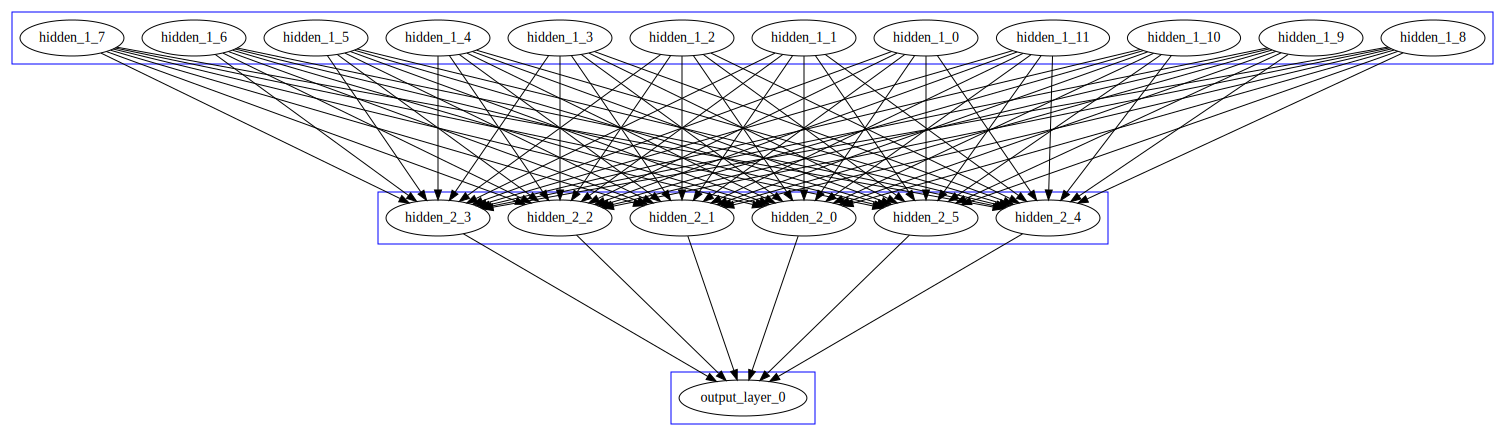

In [ ]:
## This is a helper function to display the model
def visualize_model(model):
    dot = Digraph()
    dot.attr(rankdir='TB', ranksep='2', splines='line')

    # Add nodes for each layer
    for layer in model.layers:
        output_shape = layer.output.shape[-1]
        with dot.subgraph(name='cluster_' + layer.name) as c:
            c.attr(color='blue')
            for i in range(output_shape):
                c.node(f'{layer.name}_{i}', label=f'{layer.name}_{i}')

    # Add edges between layers
    for i in range(len(model.layers) - 1):
        layer1 = model.layers[i]
        layer2 = model.layers[i + 1]
        output_shape1 = layer1.output.shape[-1]
        output_shape2 = layer2.output.shape[-1]
        for j in range(output_shape1):
            for k in range(output_shape2):
                dot.edge(f'{layer1.name}_{j}', f'{layer2.name}_{k}')

    return dot

visualize_model(model)

## Model fitting  <a name="model_fitting"></a>

The next step is to compile the model and perform the training. In order to do so, a number of hyperparameters need to be set.

- **Training time**: the training time is primarily determined by the number of epochs. A higher number of epochs means longer training, and thereby often better results, but with the risk of overfitting. A way to counteract this is early stopping, which tells the model to stop training when results stop improving.
In order to implement this concept, below the `EarlyStopping` function is used. The specified arguments are `monitor`, which represents the quantity to be monitored, and `patience`, which represents the number of epochs with no improvement after which training will be stopped. More information on such function and on its other arguments can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

- **Optimizer**: there are several optimizers available, which determine how the weights of the model are updated. In this case, the Adam optimizer is used. Other available options can be found [here](https://keras.io/api/optimizers/).
As seen in the theoretical session, the Adam optimizer is based on the stochastic gradient descent method. It calculates weights moving along the direction in which the loss function locally decreases the fastest.
In more detail, the objective is to calculate the weights $w$ that minimize the chosen loss function $L()$. Below, the loss metric is set to `poisson`. In formulas, this translates to:


$$ \min_w L(y, \hat{y}; w) $$

$$ w_{\text{new}} = w_{\text{old}} - \eta \cdot \nabla_w L(y, \hat{y}; w_{\text{old}}) $$

where:
- $\hat{y}$ represents the estimation of the model for the dependent variable
- $y$ represents the observed values for the dependent variable
- $\eta$ is the learning rate. It determines how quickly the weights of the model are updated. A higher learning rate often leads to quicker learning, but also highers the risk of overfitting.


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.01), loss='poisson', metrics=['mse'])

# Train the Model
history = model.fit(X_train_freq_NN, y_train_freq_NN, epochs=30, validation_data=(X_test_freq_NN, y_test_freq_NN), callbacks=[callback])

Epoch 1/30
16951/16951 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.5867 - mse: 22.7779 - val_loss: 0.5918 - val_mse: 26.2664
Epoch 2/30
16951/16951 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - loss: 0.5795 - mse: 20.0300 - val_loss: 0.5614 - val_mse: 26.1574
Epoch 3/30
16951/16951 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.5644 - mse: 19.2557 - val_loss: 0.5569 - val_mse: 26.1319
Epoch 4/30
16951/16951 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 0.5489 - mse: 19.6477 - val_loss: 0.5332 - val_mse: 26.0957
Epoch 5/30
16951/16951 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 0.5222 - mse: 19.2019 - val_loss: 0.5348 - val_mse: 26.0914
Epoch 6/30
16951/16951 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 0.5476 - mse: 20.8719 - val_loss: 0.5562 - val_mse: 26.1053
Epoch 7/30
16951/16951 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 0.5409 - mse: 18.9547 - val_loss: 0.5403 - val_mse: 26.1096


If the model performs well, accuracy and loss are expected not to differ too much, in terms of relative difference, between the train and the test datasets. This is the case in the model developed above.


## Hyperparameter tuning  <a name="hyp_tuning"></a>

Unlike model parameters (like weights), which are calculated by the model during training, hyperparameters are set before, given as input for the model. As they can have a relevant influence on the performance of the model, hyperparameter tuning is a fundamental step. Finding the right hyperparameters can yield to significantly better results.
With `keras`, hyperparameter tuning can be done using `keras_tuner`. More information can be found [here](https://www.tensorflow.org/tutorials/keras/keras_tuner).
The list of hyperparameters that can be tuned is quite long, for example: number of layers, number of units per layer, activation functions, optimizer, learning rate, epochs, dropout rate, early stopping, loss function.
Below, a function is defined in order to tune the following hyperparameters:

* number of units in the first dense layer
* activation function
* learning rate for the optimizer.




In [ ]:
# Define model-building function
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=(X_train_freq_NN.shape[1],)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 10-100
  hp_units = hp.Int('units', min_value=10, max_value=100, step=10)

  # Tune the activation function
  # Choose an activation function
  hp_activation = hp.Choice("activation", ["relu", "sigmoid", "tanh", "softmax", "elu", "exponential"])
  model.add(tf.keras.layers.Dense(units=hp_units, activation=hp_activation))

  # Output layer with a single neuron for regression, use 'exponential' activation for positive output
  model.add(tf.keras.layers.Dense(1, activation='exponential'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

  # Use 'poisson' loss for regression and 'mse' for accuracy
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='poisson',
                metrics=['mse'])

  return model

If on one hand bayesian optimization can be used to tune hyperparameters, a faster way to do so is through adaptive resource allocation and early-stopping. In this framework, ```hyperband``` was designed . More information can be found [here](https://keras.io/keras_tuner/api/tuners/hyperband/). Note that even this method takes a non-negligible amount of time to run.

In [ ]:
# Initialize the Hyperband tuner for hyperparameter optimization
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=20,
                     factor=3)

# EarlyStopping callback to stop training if validation loss (the function to monitor) doesn't improve for 1 epoch (value set by patience)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

# Run the Hyperband search to find the best hyperparameters
tuner.search(X_train_freq_NN, y_train_freq_NN, epochs=1, validation_split=0.2, callbacks=[stop_early])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]
# print(f"Best number of layers: {best_hps.get('num_layers')}")
print(f"Best number of nodes: {best_hps.get('units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Activation function: {best_hps.get('activation')}")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train_freq_NN, y_train_freq_NN, epochs=10, validation_split=0.2, batch_size=32)

Trial 30 Complete [00h 01m 45s]
val_loss: 0.5372233390808105

Best val_loss So Far: 0.4939974248409271
Total elapsed time: 00h 59m 49s
Best number of nodes: 60
Best learning rate: 0.001
Activation function: softmax
Epoch 1/10
13561/13561 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.6132 - mse: 16.4578 - val_loss: 0.5607 - val_mse: 30.8504
Epoch 2/10
13561/13561 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.5354 - mse: 14.8593 - val_loss: 0.5444 - val_mse: 30.8269
Epoch 3/10
13561/13561 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.5144 - mse: 12.9773 - val_loss: 0.5290 - val_mse: 30.7974
Epoch 4/10
13561/13561 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.5265 - mse: 19.1453 - val_loss: 0.5229 - val_mse: 30.7879
Epoch 5/10
13561/13561 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.5126 - mse: 16.5466 - val_loss: 0.5122 - val_mse: 30.7536
Epoch 6/10
13561/13561 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.5041 - mse: 18.5257 - val_loss: 0.5075 - val_mse: 30.7452
Epoch 7/10
13561/13561 ━━━━━━━━━━━━

## Explaining the model <a name="explaining" />
Even though weights of a neural network can be retrieved, actually understanding them quickly becomes infeasible. Even our small model already has 649 weights that interact with each other and the input variables.

In [ ]:
# Get the total number of weights in the model
weights = model.get_weights()
print("Total number of weights:", sum([i.size for i in weights]))

Total number of weights: 649


Therefore, other ways to understand the model's actions are needed.
One possible way is to use ```shap``` values. These will be explained in more details in a later session. The important thing to note here is that they give an indication of the direction the prediction is pushed in by a feature.

In [ ]:
explainer = shap.KernelExplainer(best_model.predict, shap.sample(X_train_freq_NN, 100))

# Compute SHAP values for a sample of the data
shap_values = explainer.shap_values(X_test_freq_NN[:5])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6657/6657 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6657/6657 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6657/6657 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6657/6657 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6657/6657 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].flatten(), X_test_freq_NN.iloc[0])

## Frequency of claims: comparison between GLM and Neural Networks <a name="freq_NN_vs_GLM"></a>

GLM and Neural Network models will be compared in this section on the basis of the computed metrics: mean-squared error and Poisson deviance.
As a reminder, the related formulas are:

$$ \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$
where:
*   $y_i$  is the observed value for the $i^{th}$ data point
*   $\hat{y}_i$ is the predicted value for the $i^{th}$ data point
*   $N$ is the total number of data points.

$$ D = 2 \sum_{i=1}^{N} \left[ y_i \log(\hat{\lambda}_i) - \hat{\lambda}_i \right] $$
where:
*   $y_i$  is the observed value for the $i^{th}$ data point
*   $\hat{\lambda}_i$ is the predicted value for the $i^{th}$ data point
*   $N$ is the total number of data points.

In [ ]:
# A tensorflow model will always return a 2-D array. In order to compare it to our response variable, we need to flatten it.
y_pred_best_NN = best_model.predict(X_test_freq_NN).flatten()
# Calculation of the MSE for the NN tuned model
mse_NN = mean_squared_error(y_pred_best_NN, y_test_freq_NN)
# Calculation of the Poisson deviance for the NN tuned model
poisson_deviance_NN = 2 * np.sum(y_test_freq_NN * np.log(y_test_freq_NN / y_pred_best_NN) - (y_test_freq_NN - y_pred_best_NN))

4238/4238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
print("Single metrics of interest for GLM:")
# GLM MSE
print(f"GLM Mean square error: {mse_GLM}")
# GLM Deviance
print(f"GLM Deviance: {Poisson.deviance:.2f}")
# NN MSE
print(f"NN Mean square error: {mse_NN}")
# NN Deviance
print(f"NN Deviance: {poisson_deviance_NN}")

Single metrics of interest for GLM:
GLM Mean square error: 26.175482829005183
GLM Deviance: 1152720.18
NN Mean square error: 26.061184172281223
NN Deviance: 240047.16304926606


# Severity of claims: Neural Network model <a name="sev_NN"></a>

As already seen in previous sessions, dataset ```mtpl_sev``` contains only two colums: *ClaimAmount* on the severity of claims and *IDpol*, a variable that allows to connect this dataset with the dataset on frequency claims. Below, the two datasets are merged. Observations corresponding to extreme values of *ClaimAmount* are discarded as they may alter predictions.

In [ ]:
# Count of observations for different values. This gives us some insight in the variable we are predicting
mtpl_sev["ClaimAmount_cat"] = pd.cut(mtpl_sev.ClaimAmount, bins = [0, 1000, 2000, 3000, 4000, 5000, 8000, max(mtpl_sev.ClaimAmount)], include_lowest = True)
print(mtpl_sev['ClaimAmount_cat'].value_counts().sort_index(ascending=True))

# Merging information from the dataset on frequency
mtpl_sev = pd.merge(mtpl_sev, mtpl_freq, on='IDpol')

ClaimAmount_cat
(-0.001, 1000.0]         8302
(1000.0, 2000.0]        14410
(2000.0, 3000.0]         1497
(3000.0, 4000.0]          748
(4000.0, 5000.0]          432
(5000.0, 8000.0]          555
(8000.0, 4075400.56]      695
Name: count, dtype: int64


The table above shows that the variable ClaimAmount contains some observations with very high values compared to the others. In this case, they will be included in the data set, because the aim is to also predict more extreme claims.

A process similar to the one performed for the frequency of claims is repeated also below: categorical variables are one-hot encoded and explanatory variables are scaled.

In [ ]:
scaler = StandardScaler()
# Prepare the data in order to standardize it. This involves dropping the ID column, and selecting only the numeric columns
X_sev_numeric = mtpl_sev\
    .drop(columns=['IDpol', 'ClaimNb'])\
    .select_dtypes(include=['number'])

# Scale numeric values
X_sev_scaled = pd.DataFrame(scaler.fit_transform(X_sev_numeric), columns=X_sev_numeric.columns, index=X_sev_numeric.index)
# One-hot encode
X_sev_dummies = pd.get_dummies(mtpl_sev[['Area', 'VehBrand', 'VehGas', 'Region']], columns=['Area', 'VehBrand', 'VehGas', 'Region']).astype(int)

# Create the feature dataframe
X_sev_NN = pd.concat([X_sev_dummies, X_sev_scaled], axis=1)
# Train/test split
X_train_sev_NN, X_test_sev_NN, y_train_sev_NN, y_test_sev_NN = train_test_split(X_sev_NN, mtpl_sev['ClaimAmount'], test_size=0.2, random_state=42)

### Model Setup
It's again important to think about the setup of the model and its aim. In this case, the goal is to predict the severity of a claim, given that the claim has occured. This is a regression problem, where the output is assumed to be a positive continous number.

The initial model will again be a relatively small neural network, with two hidden layers of 32 and 16 noded. The activation function of the hidden layers is kept equal to ReLU. However, the activation function of the output layer is different, as the predictions will be different.

In this case, a linear output function is used because of its simplicity. Other suitable alternatives might be:
- ReLU activation function, which has already been described
- ELU activation funtion, whose formula is: $f(x) =
\begin{cases}
x & \text{if } x \geq 0 \\
\left( e^x - 1 \right) & \text{if } x < 0
\end{cases}$

  where $x$ is the output of the last hiddent layer.

Both are capable of predicting a non-negative numeric value.

In [ ]:
# Add an input layer
model_sev = tf.keras.models.Sequential(name="claim_severity")
model_sev.add(tf.keras.Input(shape=(X_train_sev_NN.shape[1],), name="input_layer"))
# Hidden Layers
model_sev.add(tf.keras.layers.Dense(32, activation='relu', name="hidden_1"))
model_sev.add(tf.keras.layers.Dense(16, activation='relu', name="hidden_2"))
# Output Layer: Predicting claim severity
model_sev.add(tf.keras.layers.Dense(1, activation='linear', name="output_layer"))

In [ ]:
# Compile the Model
model_sev.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mse'])

# Train the Model
history = model_sev.fit(X_train_sev_NN, y_train_sev_NN, epochs=30, validation_data=(X_test_sev_NN, y_test_sev_NN))

Epoch 1/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 274049728.0000 - mse: 274049728.0000 - val_loss: 79129528.0000 - val_mse: 79129528.0000
Epoch 2/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 975060672.0000 - mse: 975060672.0000 - val_loss: 74024120.0000 - val_mse: 74024120.0000
Epoch 3/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1117788800.0000 - mse: 1117788800.0000 - val_loss: 67003660.0000 - val_mse: 67003660.0000
Epoch 4/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1530168064.0000 - mse: 1530168064.0000 - val_loss: 57924052.0000 - val_mse: 57924052.0000
Epoch 5/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 475605920.0000 - mse: 475605920.0000 - val_loss: 47038452.0000 - val_mse: 47038452.0000
Epoch 6/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1013955776.0000 - mse: 1013955776.0000 - val_loss: 30802970.0000 - val_mse: 30802970.0000
Epoch 7/30
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 434889280.0000 - mse: 434889280.0000 - val_los

# Excercise <a name="ex"></a>
Try to tune the hyperparameters of the Neural Network model for severity of claims and compare accuracy metrics with the ones of a GLM model. Which one performs better?

# Advantages and disadvantages of Neural Networks <a name="adv_dis_NN"></a>

In practice, these models are not often used to find the technical tariff. This is due to the fact that Neural Networks present a certain list of **disadvatages**, among which:

*   Limited Interpretability: Neural Networks are often considered "black-box" models. Therefore, understanding the reasoning and the impact of different explanatory variables on predictions is challenging. This can be a big disadvantage in pricing for insurance companies

*   Training time: neural networks contain a lot of weights, which all need to  be fitted. This can require an important amount of time.


However, Neural Networks present some **advantages** as well. They are especially suitable for complex problems for which a big amount of training data is available and for which interpretation of the model is less relevant. Some of these advantages are:

*   No need to manually tweak all input parameters, to capture more complex patterns
*   Superior predictive power in a range of problems
*   Ability to work with very large datasets
*   Ability to capture non-linear and complex patterns.


# Image recognition <a name="img_rec"></a>
Neural networks are incredibly versatile. Besides the more classical numeric excercises, they can also solve a variety of other problems, one of which is image recognition. This section shows a small example of this.

A dataset containing images of vehicle damage will be used. The goal here is to identify the type of damage. This can be useful for example when one wants to build a system which can automatically refer a claim to the most knowledgeable service agent.

## Download the data
This code will download the dataset from Kaggle. When running on Colab the connection will work automatically. When running it locally, [setup an API key](https://www.kaggle.com/docs/api#authentication) might be needed.

In [ ]:
# Download latest version
base_dir = kagglehub.dataset_download("gauravduttakiit/vehicle-damage-identification")

print("Path to dataset files:", base_dir)

100%|██████████| 1.49G/1.49G [00:20<00:00, 77.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gauravduttakiit/vehicle-damage-identification/versions/1


## Data preparation
Here, two datasets will be generated. This is done based on the folder structure, by `image_dataset_from_directory` helper function of `keras`. The result is a data generator, which outputs a batch of resized images, with their accompanying labels.

### Resizing
The model expects a constant input size. In this case, the input is a 3-dimensional matrix. In this matrix an image is represented as a collection of pixels, where each pixel is a tuple of Red, Green, Blue values.

To get to this constant size, the images will be resized to be 64x64 pixels.

In [ ]:
image_size = (64, 64)

datagen_train = image_dataset_from_directory(
    base_dir + "train",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=image_size,
    shuffle=True,
    interpolation="bilinear",
    verbose=True,
)

datagen_test = image_dataset_from_directory(
    base_dir + "test",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=image_size,
    shuffle=True,
    interpolation="bilinear",
    verbose=True,
)

Found 5760 files belonging to 6 classes.
Found 1440 files belonging to 6 classes.


### Build the network
As mentioned before, a Convolution Neural Network (CNN) is a popular choice when performing image classification. So this is the technique that will be applied below.

A very simple CNN, consisting of 3 convolutional layers, is built.

In [ ]:
# Build a simple CNN model
model = Sequential([
    tf.keras.Input(
        shape=(image_size[0], image_size[1], 3),
        name="input_layer"
    ),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),

    # In the end, the results need to be flattened and transformed
    # into a prediction for every class.
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(datagen_train.class_names), activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    datagen_train,
    validation_data=datagen_test,
    epochs=10  # Adjust the number of epochs as needed
)

# Save the model
model.save('vehicle_damage.keras')

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.2911 - loss: 84.8136 - val_accuracy: 0.3264 - val_loss: 1.5972
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step - accuracy: 0.3250 - loss: 1.5958 - val_accuracy: 0.3285 - val_loss: 1.5601
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.3280 - loss: 1.5633 - val_accuracy: 0.3313 - val_loss: 1.5420
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.3583 - loss: 1.5209 - val_accuracy: 0.3514 - val_loss: 1.5262
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 481s 3s/step - accuracy: 0.3752 - loss: 1.4785 - val_accuracy: 0.3458 - val_loss: 1.6001
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 516s 3s/step - accuracy: 0.3964 - loss: 1.4341 - val_accuracy: 0.3819 - val_loss: 1.5322
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 495s 3s/step - accuracy: 0.4587 - loss: 1.2892 - val_accuracy: 0.4076 - val_loss: 1.5097
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 491s 3s/step - accuracy: 0.4911 - loss: 1.1958 - val_acc

45/45 - 36s - 804ms/step - accuracy: 0.4778 - loss: 1.7708


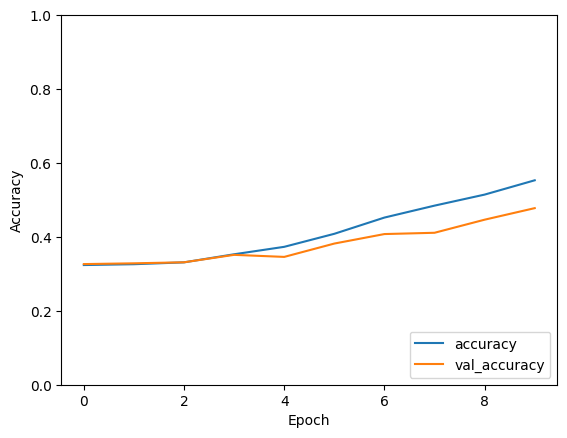

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(datagen_test, verbose=2)

In [ ]:
results_test = model.predict(datagen_test)
results_test_classes = np.argmax(results_test, axis=1)

45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 812ms/step


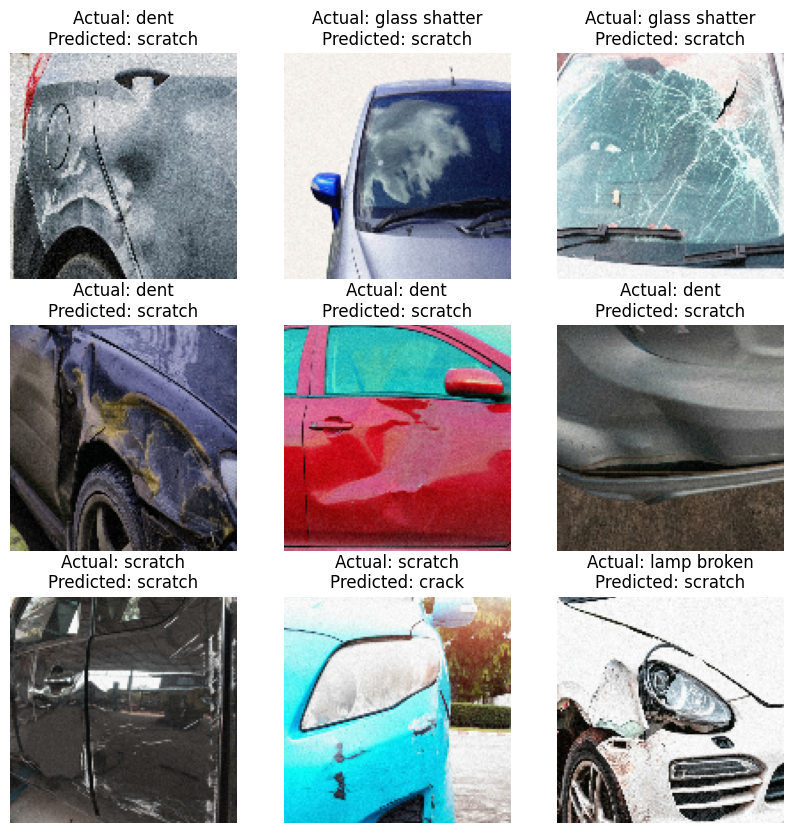

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in datagen_test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_label = datagen_train.class_names[np.argmax(labels[i])]
        predicted_label = datagen_train.class_names[results_test_classes[i]]
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        plt.axis("off")
plt.show()

# Summary  <a name="sum"></a>

In this Session, Neural Networks have been explored and applied to two actuarial problems. A comparison with a more used traditional technique (GLM) has been made.

Even though this tutorial shows the basics of Neural Networks, there's a lot more to explore, especially when it comes to larger networks and so-called deep learning (neural networks with many layers). However, for the frequency and severity datasets that are used in this tutorial, such a network is overkill.
To dig deeper, there are excellent resources online, for example on the  [Tensorflow](https://www.tensorflow.org/tutorials) website.

An example of possible further uses is finally given through an image recognition problem.
